# 変分ベイズ推論による混合ガウス分布のパラメータ推定
千葉工業大学 三上泰史  

(c)2017 Taishi Mikami 

This software is released under the MIT License, see LICENSE

## 流れ
このソースコードは、k個の2次元ガウス分布を含む混合ガウス分布から生成されたデータを使い、EMアルゴリズムを実装したものです。
1. クラスタリング対象データを生成
2. 事後分布のパラメータの初期設定 
3. K-meansを用いて平均値の初期値を定義
4. 負担率の初期化
5. 共分散、平均、クラスタに属するデータ数の三つの統計量を計算
6. Mステップの実行:α、β、ν、ｍ、Wを計算
7. Eステップの実行:負担率を更新
8. 5から7までを収束するまで繰り返す(未実装...)

In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
#ディガンマ関数のライブラリ
from scipy.special import digamma
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt
import random

### 2次元データの生成

In [2]:
def dataset(mu,cov,pi):
    for i in range(len(mu)):
        samplesB = np.random.multivariate_normal(mu[i],cov[i],int(N*pai[i])).T
        if(i>=1):
            samplesA = np.column_stack((samplesA,samplesB))
        else:
            samplesA = samplesB
    sample = np.c_[samplesA[0],samplesA[1]]
    plt.figure(figsize=(6, 6))
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)
    plt.scatter(sample[:,0],sample[:,1],color='g',marker='+',alpha=0.8)
    return sample

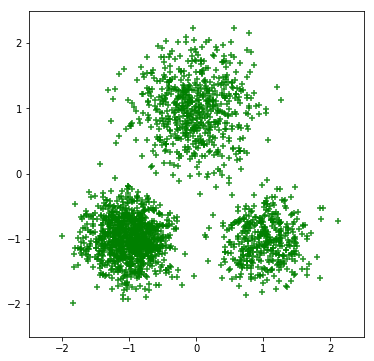

In [3]:
#データ数
N = 2000
#平均
mu = [[0,1],[-1,-1],[1,-1]]
#共分散
cov = [[[0.2,0.],[0.,0.2]],[[0.1,0.],[0.,0.1]],[[0.1,0.],[0.,0.1]],[[0.2,0.],[0.,0.2]]]
#混合率
pai=[0.3,0.5,0.2]
#事後分布の個数
K=8
#次元
D=2
samples = dataset(mu,cov,pai)
plt.scatter(samples[:,0],samples[:,1],color='g',marker='+',alpha=0.2)

### Kmeans法による平均値の推定

In [4]:
class KMeans:
    def __init__(self):
        self.k = K
        self.N = N
        self.reset()
        
    def cluster_center(self,samples):
        clus_center = []
        for i in range(self.k):
            clus_center.append([random.uniform(min(samples[:,0]),max(samples[:,0])),random.uniform(min(samples[:,1]),max(samples[:,1]))])
        self.mu = np.array(clus_center)
        
    def reset(self):
        self.label = []
        self.count = np.zeros((self.k,1))
        self.sum = np.zeros((self.k,2))
        self.t = np.zeros((self.k,1))
        
    def draw(self,sample,mu,label):
        
        #新しい描画を開始
        plt.figure(figsize=(6, 6))
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        plt.scatter(sample[:,0],sample[:,1],s=20,c=label,marker='+',edgecolors='k',alpha=0.4)
        plt.scatter(mu[:,0],mu[:,1],s=100,marker="x",edgecolors='k')
        
    def EM_step(self,sample,mu):
        #変数の初期化
        self.reset()
        
        #2点間の二乗距離
        for n in range(self.N):
            distance = []
            distance = [np.linalg.norm(self.mu[i] - sample[n]) for i in range(self.k)]
            
            #クラス分け
            self.label.append(distance.index(min(distance)))
            self.count[distance.index(min(distance))] += 1
            self.sum[distance.index(min(distance))] += sample[n]
        
        #クラスタ中心の更新
        for i in range(0,self.k):
            self.mu[i] = self.sum[i]/self.count[i]

推定結果
[[-0.90549298 -0.69570755]
 [-1.34921787 -1.02885939]
 [-0.82208333 -1.25933305]
 [-0.1005343   0.42021666]
 [ 1.01763121 -1.01864346]
 [-0.44324687  1.10108578]
 [ 0.13454956  1.60335255]
 [ 0.396865    0.90836488]]


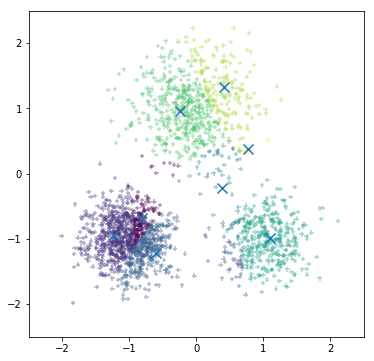

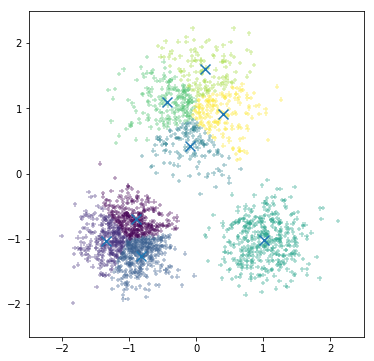

In [5]:
model = KMeans()
model.cluster_center(samples)
model.EM_step(samples,model.mu)
model.draw(samples,model.mu,model.label)
for i in range(10):
    model.EM_step(samples,model.mu)
model.draw(samples,model.mu,model.label)
clus_center = model.mu
print("推定結果")
print(clus_center)

In [6]:
def make_gauss_model(mu,sigma):
    gauss = []
    for i in range(K):
        gauss.append(multivariate_normal(mean=mu[i],cov=sigma[i]))
    return gauss

In [7]:
def draw(gauss):
    plt.figure(figsize=(6, 6))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    
    for i in range(K):
        z = gauss[i].pdf(pos)
        if pai[i] > 0.01: 
            plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    for i in range(N):
        #plt.xlim(min(samples[:,0])+0.1,max(samples[:,0])+0.1)
        #plt.ylim(min(samples[:,1])+0.1,max(samples[:,1])+0.1)
        plt.scatter(samples[i][0],samples[i][1],color="g",marker='+',alpha=0.3)

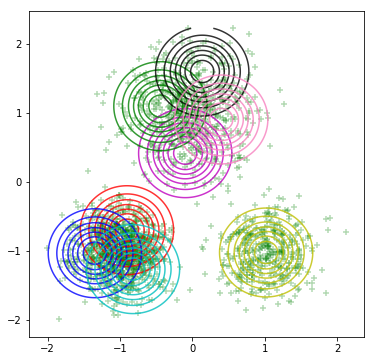

In [8]:
g_sigma = [[[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]]]
pai = [1.0/K for i in range(K)]
clus = ["r","b","c","m","y","g","k", '#f781bf']
gauss = make_gauss_model(clus_center,g_sigma)
draw(gauss)

### 負担率の初期化

In [9]:
def ganma_init():
    ganma = []
    for i in range(N):
        sum_p = 0.0
        p=[]
        for j in range(K):
            sum_p += pai[j]*gauss[j].pdf([samples[i][0],samples[i][1]])
        for j in range(K):
            p.append(pai[j]*gauss[j].pdf([samples[i][0],samples[i][1]])/sum_p)
        ganma.append(p)
    return ganma

### 3つの統計量の計算

In [10]:
def cal(ganma):
    #行列の初期化
    mu = np.zeros((K,D))
    S = np.zeros((K,D,D))
    N_k = []
    
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
             sum_r += ganma[n][k]
        N_k.append(sum_r)
        
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
            sum_r += ganma[n][k]*samples[n]
        mu[k] = sum_r/N_k[k]
        sigma = []
        sigma = [samples[j]-mu[k] for j in range(N)]
        tmp = np.zeros((1,D,D))
        for n in range(N):
            tmp += (ganma[n][k]*sigma[n])*sigma[n][:, np.newaxis]
        tmp2 = tmp/N_k[k]
        S[k] = tmp2
    return N_k,mu,S

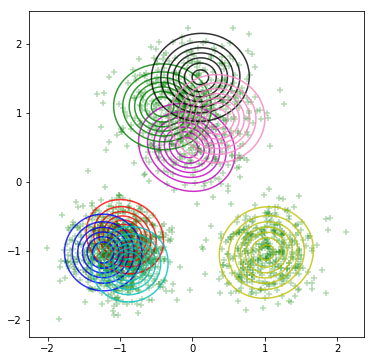

In [11]:
ganma = ganma_init()
N_k,mu,S = cal(ganma)
gauss = make_gauss_model(mu,S)
draw(gauss)

### M-step

In [12]:
def M_step(N_k,mu,S):
    alpha_0 = 0.01
    beta_0 = 0.01
    nu_0 = 1.0
    m_0 = np.zeros((K,D))
    m = np.zeros((K,D))
    W_0 = np.identity(2)
    alpha=[]
    beta=[]
    nu=[]
    W = np.zeros((K,D,D))
    for k in range(K):
        alpha.append(alpha_0 + N_k[k])
        beta.append(beta_0 + N_k[k])
        nu.append(nu_0 + N_k[k])
        m[k] = (beta_0*m_0[k] + N_k[k]*mu[k])/beta[k]
    sigma = []
    sigma = [mu[j]-m_0[j] for j in range(K)]
    for k in range(K):
        tmp = beta_0*N_k[k]*sigma[k]*sigma[k][:, np.newaxis]/(beta_0 + N_k[k])
        tmp2 = la.inv(W_0)+N_k[k]*S[k]+tmp
        W[k] = la.inv(tmp2)
    return alpha,beta,nu,m,W

### E-step

In [13]:
def E_step(alpha,beta,nu,m,W):
    E_ln_A = []
    E_ln_pi = []
    E_mu_A = []
    r = []
    for k in range(K):
        tmp = sum([digamma((nu[k]+1-i)/2)for i in range(1,D+1)])
        E = tmp +D*math.log(2)+math.log(la.norm(W[k]))
        E_ln_A.append(E)
        
        E = digamma(alpha[k])-digamma(sum(alpha))
        E_ln_pi.append(E)
    for n in range(N):
        tmp = [(D/beta[k])+nu[k]*np.dot((samples[n] - m[k]),np.dot(W[k],(samples[n] - m[k]).T)) for k in range(K)]
        E_mu_A.append(tmp)
    for n in range(N):
        tmp = [np.exp(np.array(E_ln_pi[k]) + np.array(E_ln_A[k])/2 - D*math.log(2*math.pi)/2-np.array(E_mu_A[n][k])/2) for k in range(K)]
        for k in range(K):
            if tmp[k] < 1e-10:
                tmp[k] = 1e-10
        tmp2 = np.array(tmp)/sum(tmp)
        
        r.append(tmp2)
    return E_ln_A,E_ln_pi,E_mu_A,r

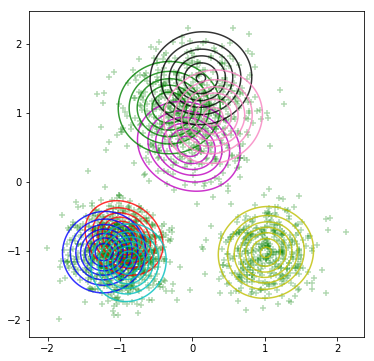

count:0
[ 0.16715871  0.15165292  0.1793799   0.06645355  0.20009487  0.0980037
  0.05712113  0.07838567]


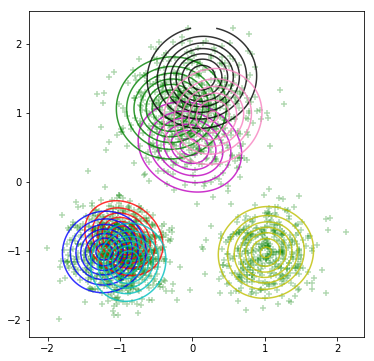

count:1
[ 0.16503002  0.15027698  0.18281949  0.06243931  0.20007564  0.10709205
  0.05158394  0.07893303]


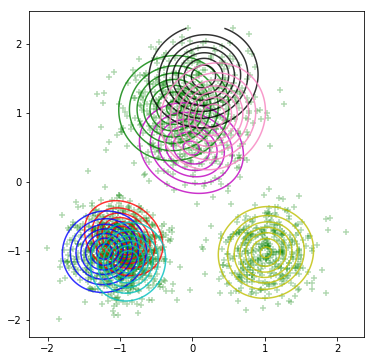

count:2
[ 0.16186395  0.14866088  0.18756852  0.05645649  0.20003322  0.12029856
  0.04405953  0.07930935]


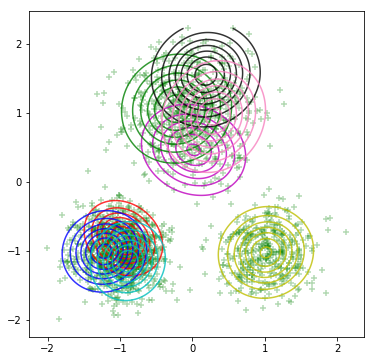

count:3
[ 0.15733378  0.14648665  0.19424614  0.04783444  0.19999753  0.13915419
  0.03424602  0.07895184]


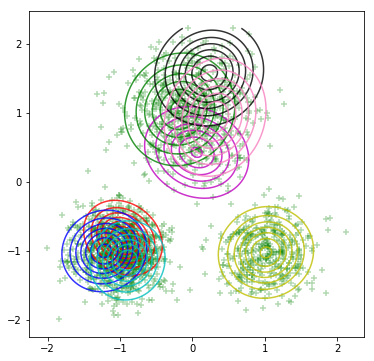

count:4
[ 0.15090014  0.14341485  0.20371313  0.0362078   0.19997236  0.16494117
  0.02256731  0.07653406]


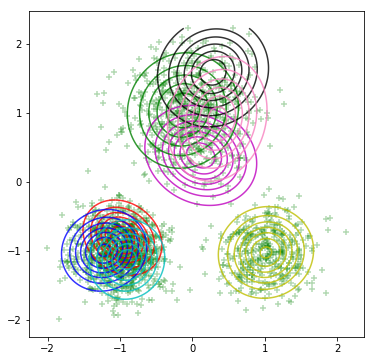

count:5
[ 0.14177488  0.13899447  0.2171851   0.0224805   0.19994942  0.19712643
  0.01104046  0.06970021]


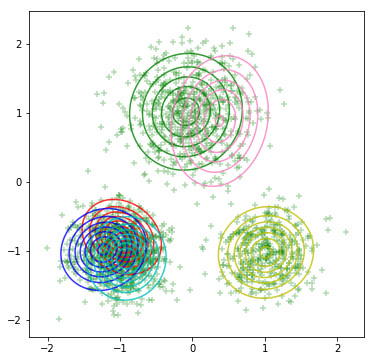

count:6
[ 0.12891254  0.13256671  0.23634229  0.00986304  0.19990138  0.2315411
  0.00311857  0.05600887]


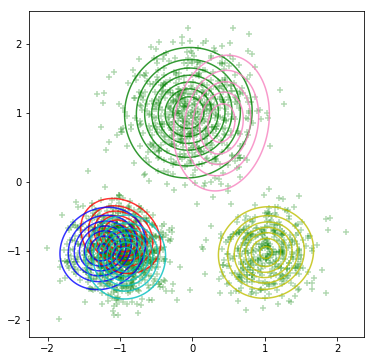

count:7
[  1.11156157e-01   1.23151867e-01   2.63334413e-01   2.31288596e-03
   1.99790280e-01   2.62157350e-01   1.94413287e-04   3.61972937e-02]


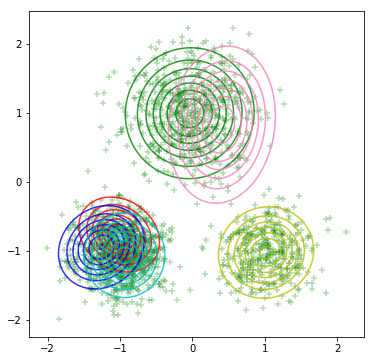

count:8
[  8.77639782e-02   1.09367743e-01   3.00364633e-01   6.05599077e-05
   1.99632182e-01   2.84875058e-01   1.09208539e-39   1.65051522e-02]


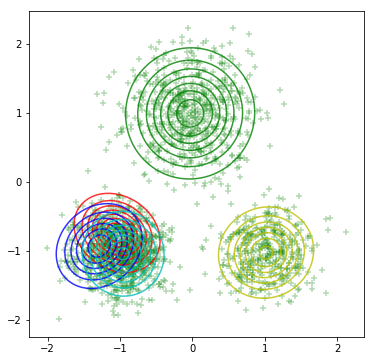

count:9
[  5.96678686e-02   8.96562644e-02   3.48118601e-01   3.57649441e-47
   1.99471854e-01   2.97496190e-01   1.06589452e-47   4.33169585e-03]


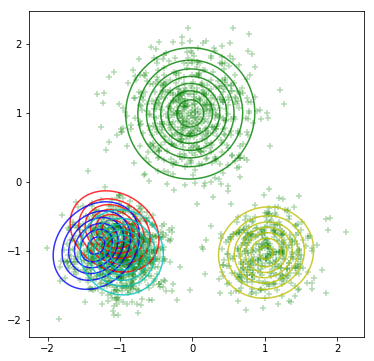

count:10
[  3.14263097e-02   6.36267216e-02   4.02430402e-01   1.06570754e-47
   1.99330263e-01   3.01628589e-01   1.06570754e-47   3.25469869e-04]


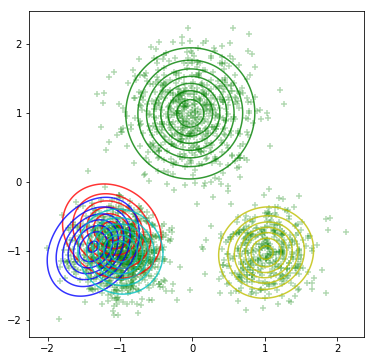

count:11
[  1.08380237e-02   3.50917038e-02   4.51705237e-01   1.06553490e-47
   1.99225484e-01   3.02121922e-01   1.06553490e-47   5.12004597e-29]


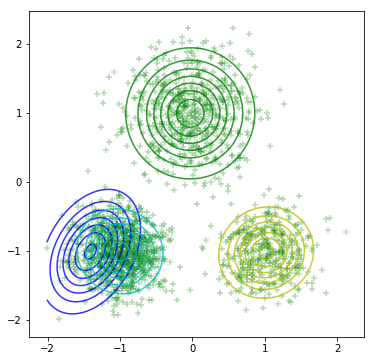

count:12
[  1.84343493e-03   1.29158624e-02   4.83093558e-01   1.06534257e-47
   1.99138940e-01   3.01999504e-01   1.06534257e-47   1.06534257e-47]


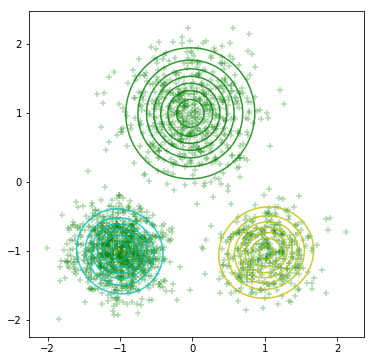

count:13
[  1.04237250e-05   2.62514145e-03   4.95509270e-01   1.06518004e-47
   1.99067869e-01   3.01900337e-01   1.06518004e-47   1.06518004e-47]


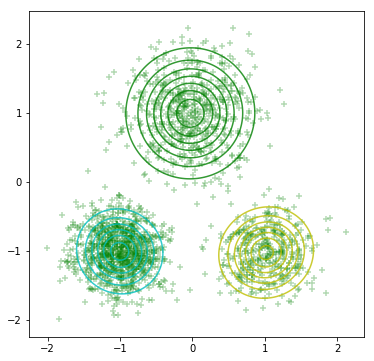

count:14
[  1.07073393e-47   1.20405788e-04   4.98280472e-01   1.06523280e-47
   1.99024801e-01   3.01857873e-01   1.06523280e-47   1.06523280e-47]


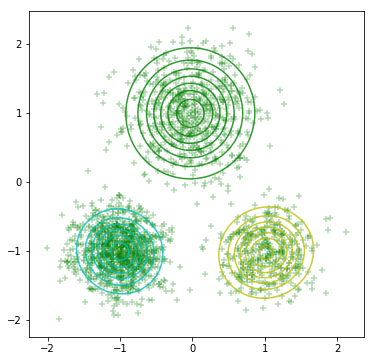

count:15
[  1.06530976e-47   5.38180880e-44   4.98624467e-01   1.06530976e-47
   1.99008322e-01   3.01841730e-01   1.06530976e-47   1.06530976e-47]


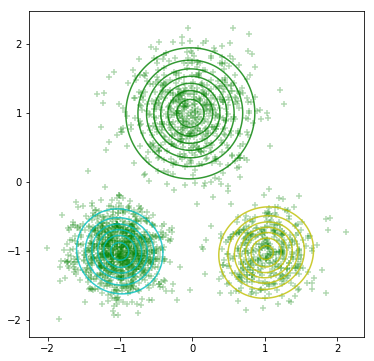

count:16
[  1.06527542e-47   1.06527542e-47   4.98637491e-01   1.06527542e-47
   1.99004102e-01   3.01833393e-01   1.06527542e-47   1.06527542e-47]


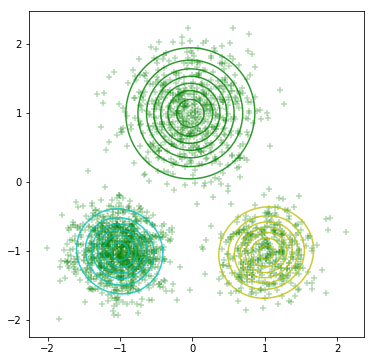

count:17
[  1.06527478e-47   1.06527478e-47   4.98639123e-01   1.06527478e-47
   1.99003656e-01   3.01832207e-01   1.06527478e-47   1.06527478e-47]


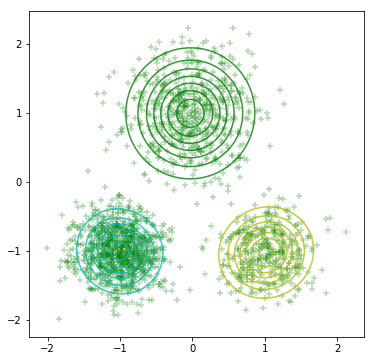

count:18
[  1.06527475e-47   1.06527475e-47   4.98639343e-01   1.06527475e-47
   1.99003618e-01   3.01832025e-01   1.06527475e-47   1.06527475e-47]


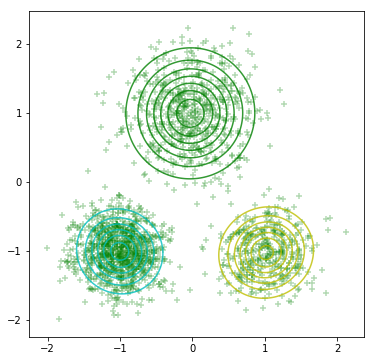

count:19
[  1.06527475e-47   1.06527475e-47   4.98639373e-01   1.06527475e-47
   1.99003617e-01   3.01831996e-01   1.06527475e-47   1.06527475e-47]


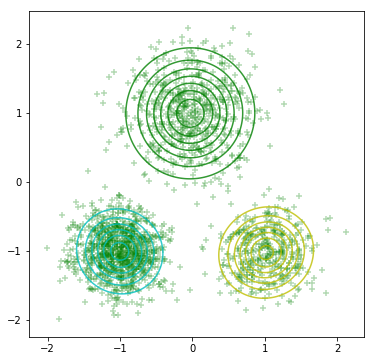

count:20
[  1.06527475e-47   1.06527475e-47   4.98639378e-01   1.06527475e-47
   1.99003617e-01   3.01831991e-01   1.06527475e-47   1.06527475e-47]


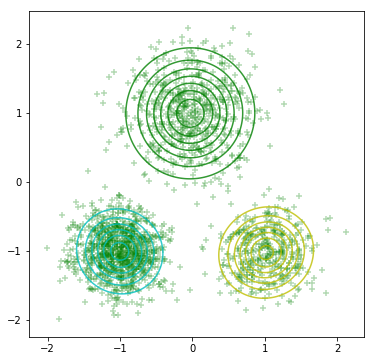

count:21
[  1.06527475e-47   1.06527475e-47   4.98639378e-01   1.06527475e-47
   1.99003617e-01   3.01831991e-01   1.06527475e-47   1.06527475e-47]


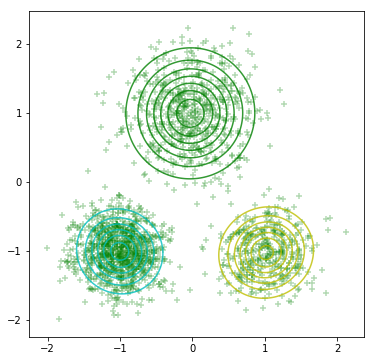

count:22
[  1.06527475e-47   1.06527475e-47   4.98639378e-01   1.06527475e-47
   1.99003617e-01   3.01831991e-01   1.06527475e-47   1.06527475e-47]


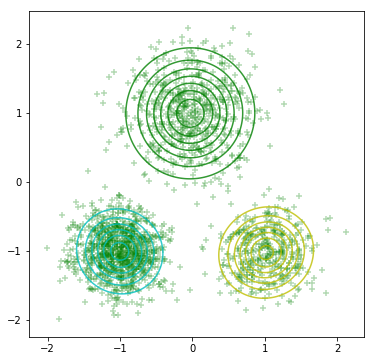

count:23
[  1.06527475e-47   1.06527475e-47   4.98639378e-01   1.06527475e-47
   1.99003617e-01   3.01831991e-01   1.06527475e-47   1.06527475e-47]


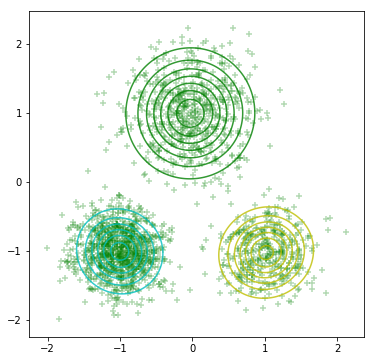

count:24
[  1.06527475e-47   1.06527475e-47   4.98639378e-01   1.06527475e-47
   1.99003617e-01   3.01831991e-01   1.06527475e-47   1.06527475e-47]


In [16]:
count = 25
pai2 = []
for i in range(count):
    alpha,beta,nu,m,W = M_step(N_k,mu,S)
    E_ln_A,E_ln_pi,E_mu_A,ganma = E_step(alpha,beta,nu,m,W)
    pai2.append(pai)
    pai = np.exp(E_ln_pi)
    N_k,mu,S = cal(ganma)
    gauss = make_gauss_model(mu,S)
    draw(gauss)
    plt.show()
    print("count:{}".format(i))
    print(pai)

### 混合率の推移

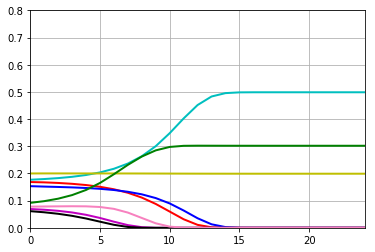

In [18]:
x = [i for i in range(count)]
y = []
for k in range(K):
    y =  [pai2[j][k] for j in range(count)]
    plt.plot(x,y,linewidth=2, color=clus[k])
    plt.xlim(0,count-1)
    plt.ylim(0,0.8)
    plt.grid(True)